This notebook is used to determine the frequency of treatment process trains

In [2]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

Redoing analysis with focus on treatment objective
1. Read df_latest_2 which includes Facility Activity = Active/Inactive
2.

In [7]:
# df_latest has sdwis data for all 4 quarters and drops duplicates. df_latest_2 includes Facility Activity Status = Active/Inactive
sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\df_latest_2.csv')

In [8]:
# Drop rows with duplicate PWS ID, Facility ID and treatment unit
sdwis_filtered = sdwis[['PWS ID','Facility Id','PWS Name', 'Population Served Count', 'Activity Status', 'Facility Activity', 'Primary Source', 'PWS Type','Treatment Process','Treatment Objective']].drop_duplicates(subset = ['PWS ID','Facility Id','Treatment Process'])
# Remove rows without an treatment process listed
sdwis_filtered = sdwis_filtered.dropna(subset=['Treatment Process'])
# Remove PWS ID and Facility with only 1 treatment process
# sdwis_filtered = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])>1).reset_index()

In [9]:
print('Before filtering SDWIS:', len(sdwis))
print('After filtering SDWIS:', len(sdwis_filtered) )

Before filtering SDWIS: 217028
After filtering SDWIS: 206567


In [37]:
unique_treatment_objective = sdwis_filtered.groupby(['Treatment Objective','Treatment Process']).size().reset_index()
unique_treatment_objective = unique_treatment_objective.sort_values(['Treatment Objective',0],ascending=[True,False])
unique_treatment_objective.rename(columns={0:'Frequency'},inplace=True)
unique_treatment_objective.reset_index(inplace = True,drop='index')
# Drop pairs that have frequency < 10
# unique_treatment_objective.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_objective_list.csv')

len(unique_treatment_objective['Treatment Process'].unique())

68

1. Filter for each treatment objective. 
2. Check the combination of treatment processes used. 
3. Create table of binary output

In [94]:
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [180]:
# Filter for particulate removal

sdwis_filtered_particulate_removal = sdwis_filtered[sdwis_filtered['Treatment Objective']=='Corrosion control']
decimal_list = []

# Create dataframe with PWS ID, Facility ID and columns that denote the unique treatment processes for that treatment objective
cols = np.concatenate([['PWS ID'], ['Facility Id'],sdwis_filtered_particulate_removal['Treatment Process'].unique(),['decimal'],['Treatment list']])
sdwis_filtered_particulate_removal_df = pd.DataFrame(columns=cols)

for pws in sdwis_filtered_particulate_removal['PWS ID'].unique():
    for facility in sdwis_filtered_particulate_removal[(sdwis_filtered_particulate_removal['PWS ID']==pws)]['Facility Id'].unique():
        temp = sdwis_filtered_particulate_removal[(sdwis_filtered_particulate_removal['PWS ID']==pws) & (sdwis_filtered_particulate_removal['Facility Id']==facility)]
        temp_df = dict()
        temp_df['PWS ID'] = pws
        temp_df['Facility Id'] = facility
        temp_df['Treatment list'] = temp['Treatment Process'].values
        for treatment in temp['Treatment Process'].values:
            temp_df[treatment]=1
        
        sdwis_filtered_particulate_removal_df = pd.concat([sdwis_filtered_particulate_removal_df,pd.Series(temp_df).to_frame().T],ignore_index=True)
        sdwis_filtered_particulate_removal_df = sdwis_filtered_particulate_removal_df.fillna(0)
        decimal_list.append(binatodeci(sdwis_filtered_particulate_removal_df.iloc[-1,2:-1].values))

sdwis_filtered_particulate_removal_df['decimal'] = decimal_list
sdwis_filtered_particulate_removal_df

,PWS ID,Facility Id,pH Adjustment,Lime - Soda Ash Addition,"Inhibitor, Orthophosphate","Inhibitor, Polyphosphate","Inhibitor, Hexametaphosphate","Inhibitor, Silicate","pH Adjustment, Post",Sequestration,...,"Aeration, Slat Tray","Aeration, Cascade",Coagulation,"Activated Carbon, Granular","Hypochlorination, Pre",Ion Exchange,"Aeration, Spray","Reducing Agent, Sodium Bisulfate",decimal,Treatment list
0,WY5680085,15611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67108864.0,[pH Adjustment]
1,WY5601198,15722,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100663296.0,"[Lime - Soda Ash Addition, pH Adjustment]"
2,WY5600236,18115,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16777216.0,"[Inhibitor, Orthophosphate]"
3,WY5600222,15694,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16777216.0,"[Inhibitor, Orthophosphate]"
4,WY5600183,15691,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25165824.0,"[Inhibitor, Orthophosphate, Inhibitor, Polypho..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18161,010106001,201,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75497472.0,"[Inhibitor, Polyphosphate, pH Adjustment]"
18162,010106001,200,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75497472.0,"[Inhibitor, Polyphosphate, pH Adjustment]"
18163,010106001,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75497472.0,"[Inhibitor, Polyphosphate, pH Adjustment]"
18164,010106001,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75497472.0,"[Inhibitor, Polyphosphate, pH Adjustment]"


In [181]:
len(sdwis_filtered_particulate_removal_df['decimal'].unique())

sdwis_filtered_particulate_removal_frequency_df = sdwis_filtered_particulate_removal_df.groupby('decimal').size().reset_index()
sdwis_filtered_particulate_removal_frequency_df['treatment list'] = sdwis_filtered_particulate_removal_df.groupby('decimal').first()['Treatment list'].values
sdwis_filtered_particulate_removal_frequency_df = sdwis_filtered_particulate_removal_frequency_df.sort_values(0,ascending=False)
sdwis_filtered_particulate_removal_frequency_df.rename(columns={0:'Frequency'},inplace=True)

# sdwis_filtered_particulate_removal_frequency_df

In [182]:
# sdwis_filtered_particulate_removal_df.to_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_train_output\corrosion_control\sdwis_filtered_corrosion_control_df.csv')
# sdwis_filtered_particulate_removal_frequency_df.to_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_train_output\corrosion_control\sdwis_filtered_corrosion_control_frequency.csv')

In [41]:
sdwis_filtered[(sdwis_filtered['PWS ID']=='WY5680001') & (sdwis_filtered['Facility Id']=='15159')]

,PWS ID,Facility Id,PWS Name,Population Served Count,Activity Status,Facility Activity,Primary Source,PWS Type,Treatment Process,Treatment Objective
22,WY5680001,15159,VETERANS ADMINISTRATION MEDICAL CENTER,470,Active,Active,Surface water,Community water system,Coagulation,Particulate removal
23,WY5680001,15159,VETERANS ADMINISTRATION MEDICAL CENTER,470,Active,Active,Surface water,Community water system,"Filtration, Ultrafiltration",Particulate removal
24,WY5680001,15159,VETERANS ADMINISTRATION MEDICAL CENTER,470,Active,Active,Surface water,Community water system,"Hypochlorination, Post",Disinfection
25,WY5680001,15159,VETERANS ADMINISTRATION MEDICAL CENTER,470,Active,Active,Surface water,Community water system,Sedimentation,Particulate removal


In [36]:
sdwis_filtered[(sdwis_filtered['PWS ID']=='WY5680092') & (sdwis_filtered['Facility Id']=='15793')]

,PWS ID,Facility Id,PWS Name,Population Served Count,Activity Status,Facility Activity,Primary Source,PWS Type,Treatment Process,Treatment Objective
9,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,"Activated Carbon, Powdered",Taste / odor control
10,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,Coagulation,Particulate removal
11,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,"Filtration, Rapid Sand",Particulate removal
12,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,Flocculation,Particulate removal
13,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,"Hypochlorination, Post",Disinfection
14,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,Permanganate,Taste / odor control
15,WY5680092,15793,YNP-MAMMOTH HOT SPRINGS,2600,Active,Active,Surface water,Community water system,Sedimentation,Particulate removal


In [39]:
sdwis_filtered[(sdwis_filtered['PWS ID']=='WY5680085') & (sdwis_filtered['Facility Id']=='15611')]

,PWS ID,Facility Id,PWS Name,Population Served Count,Activity Status,Facility Activity,Primary Source,PWS Type,Treatment Process,Treatment Objective
16,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,Coagulation,Particulate removal
17,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,"Filtration, Rapid Sand",Particulate removal
18,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,Flocculation,Particulate removal
19,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,"Hypochlorination, Post",Disinfection
20,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,Sedimentation,Particulate removal
21,WY5680085,15611,YNP-OLD FAITHFUL,6225,Active,Active,Surface water,Community water system,pH Adjustment,Corrosion control


Cleaning up treatment train information
1. Filter for Activity Status = Active (and Facility Status = Active this was removed for the USGS dataset)- Updated to be both Active and Inactive
2. Remove PWS ID- Facility ID pairs with only 1 treatment step
3. Get frequency of Treatment Process-Treatment Objective pairs. Drop pairs with frequency less than 10
4. Map physical/chemical classification
5. Map chemical type
6. Map physical type (Not sure how to do this yet)


In [11]:
# df_latest has sdwis data for all 4 quarters and drops duplicates. df_latest_2 includes Facility Activity Status = Active/Inactive
sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\df_latest_2.csv')
# sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv')
# Read mapping file
treatment_classification = pd.read_excel(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\grouped_treatment_processes_2020_MH.xlsx')

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21288\2158044353.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  sdwis = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\df_latest.csv')


In [12]:
# Drop rows with duplicate PWS ID, Facility ID and treatment unit
sdwis_filtered = sdwis[['PWS ID','Facility Id','PWS Name', 'Population Served Count', 'Activity Status', 'Facility Activity', 'Primary Source', 'PWS Type','Treatment Process','Treatment Objective']].drop_duplicates(subset = ['PWS ID','Facility Id','Treatment Process'])
# Filter for Facility activity = Active
# sdwis_filtered = sdwis_filtered[sdwis_filtered['Facility Activity']=='Active']
# Remove rows without an treatment process listed
sdwis_filtered = sdwis_filtered.dropna(subset=['Treatment Process'])
# Remove PWS ID and Facility with only 1 treatment process
sdwis_filtered = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])>1).reset_index()
# sdwis_filtered_two_step = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])==2)

In [13]:
print('Before filtering SDWIS:', len(sdwis))
print('After filtering SDWIS:', len(sdwis_filtered) )

Before filtering SDWIS: 163436
After filtering SDWIS: 123872


In [14]:
unique_treatment = sdwis_filtered.groupby(['Treatment Process','Treatment Objective']).size().reset_index()
unique_treatment = unique_treatment.sort_values(0,ascending=False)
unique_treatment.rename(columns={0:'Frequency'},inplace=True)
# Drop pairs that have frequency < 10
# unique_treatment.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list.csv')
# unique_treatment = unique_treatment[unique_treatment['Frequency']>10]

In [15]:
unique_treatment_process = pd.DataFrame(unique_treatment['Treatment Process'].unique()).reset_index(drop = True)
# unique_treatment_process.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_process_list.csv')

In [16]:
unique_treatment_classified = unique_treatment.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')
# unique_treatment_classified.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list_classified.csv')
# unique_treatment_classified

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21288\3059360086.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21288\3059360086.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')


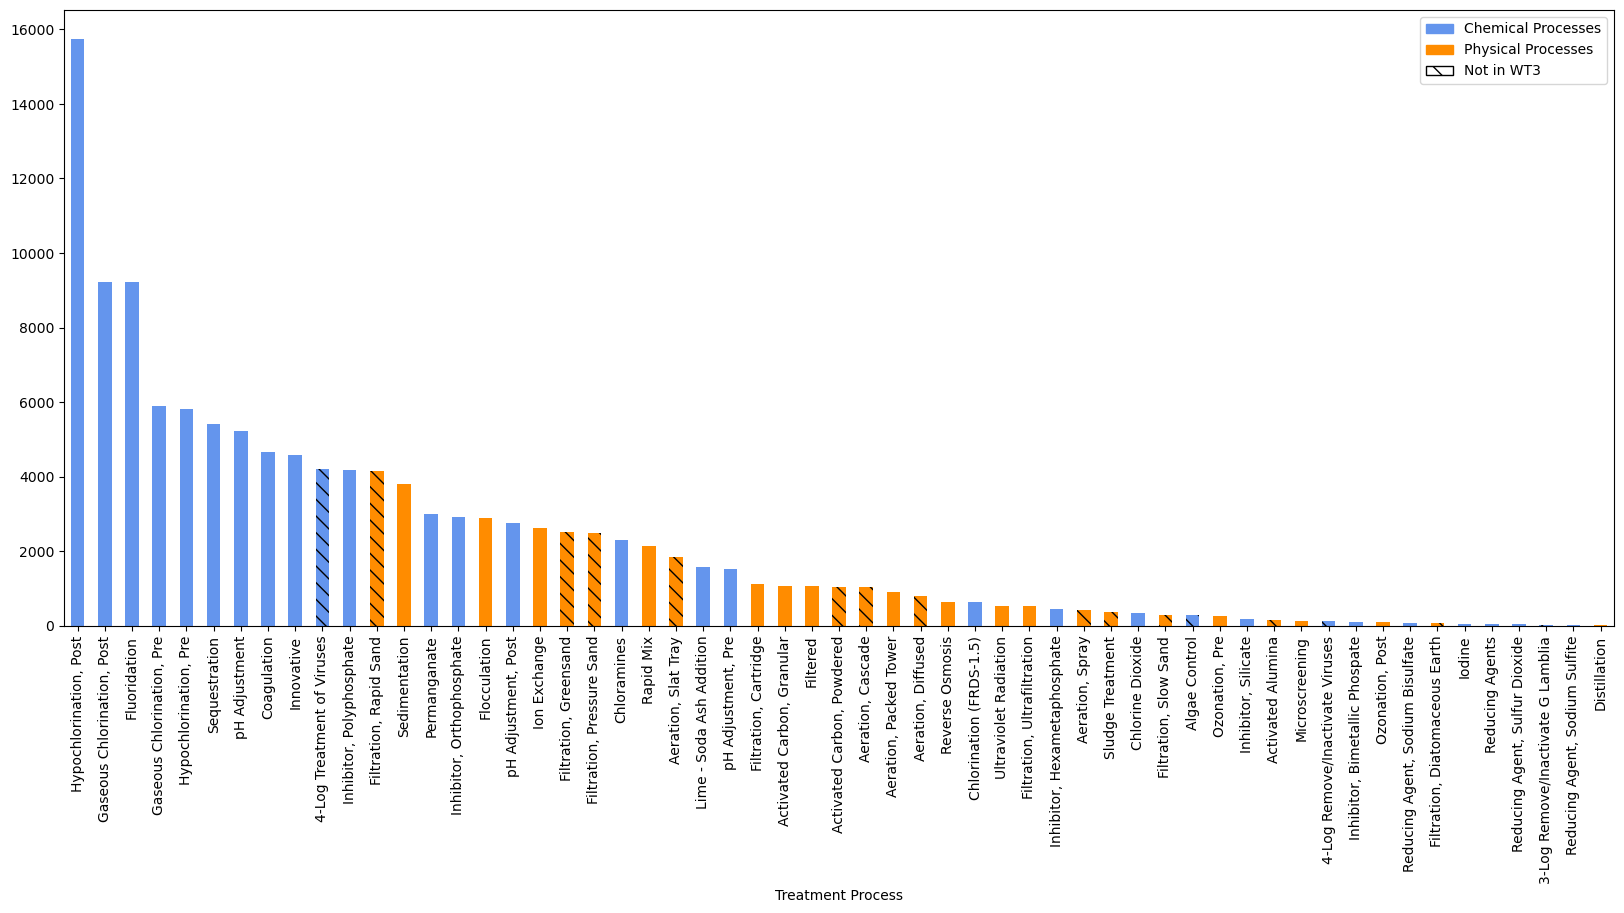

In [17]:
unique_treatment_frequency = unique_treatment.groupby(['Treatment Process']).sum().reset_index()
unique_treatment_frequency = unique_treatment_frequency.sort_values('Frequency',ascending=False)
# unique_treatment_frequency.to_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files_2024\sdwis_treatment_list_frequency.csv')

unique_treatment_frequency = unique_treatment_frequency.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')

fig, ax = plt.subplots()
unique_treatment_frequency.plot.bar(ax = ax, x='Treatment Process', y = 'Frequency', figsize=(20,8))
bars = ax.patches
hatches = ["" if x == 'yes' else '\\\\' for x in unique_treatment_frequency['In WT3']]
colors = ["cornflowerblue" if x == 'chemical' else 'darkorange' for x in unique_treatment_frequency['physical_chemical']]

for bar,hatch,color in zip(bars,hatches,colors):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)

chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')
in_wt3 = mpatches.Patch(edgecolor='black', facecolor= 'white', hatch = "\\" , label = 'Not in WT3')

ax.legend(handles=[chemical_patch,physical_patch,in_wt3])
# ax.set_yscale('log')    

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21288\2142264230.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21288\2142264230.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')


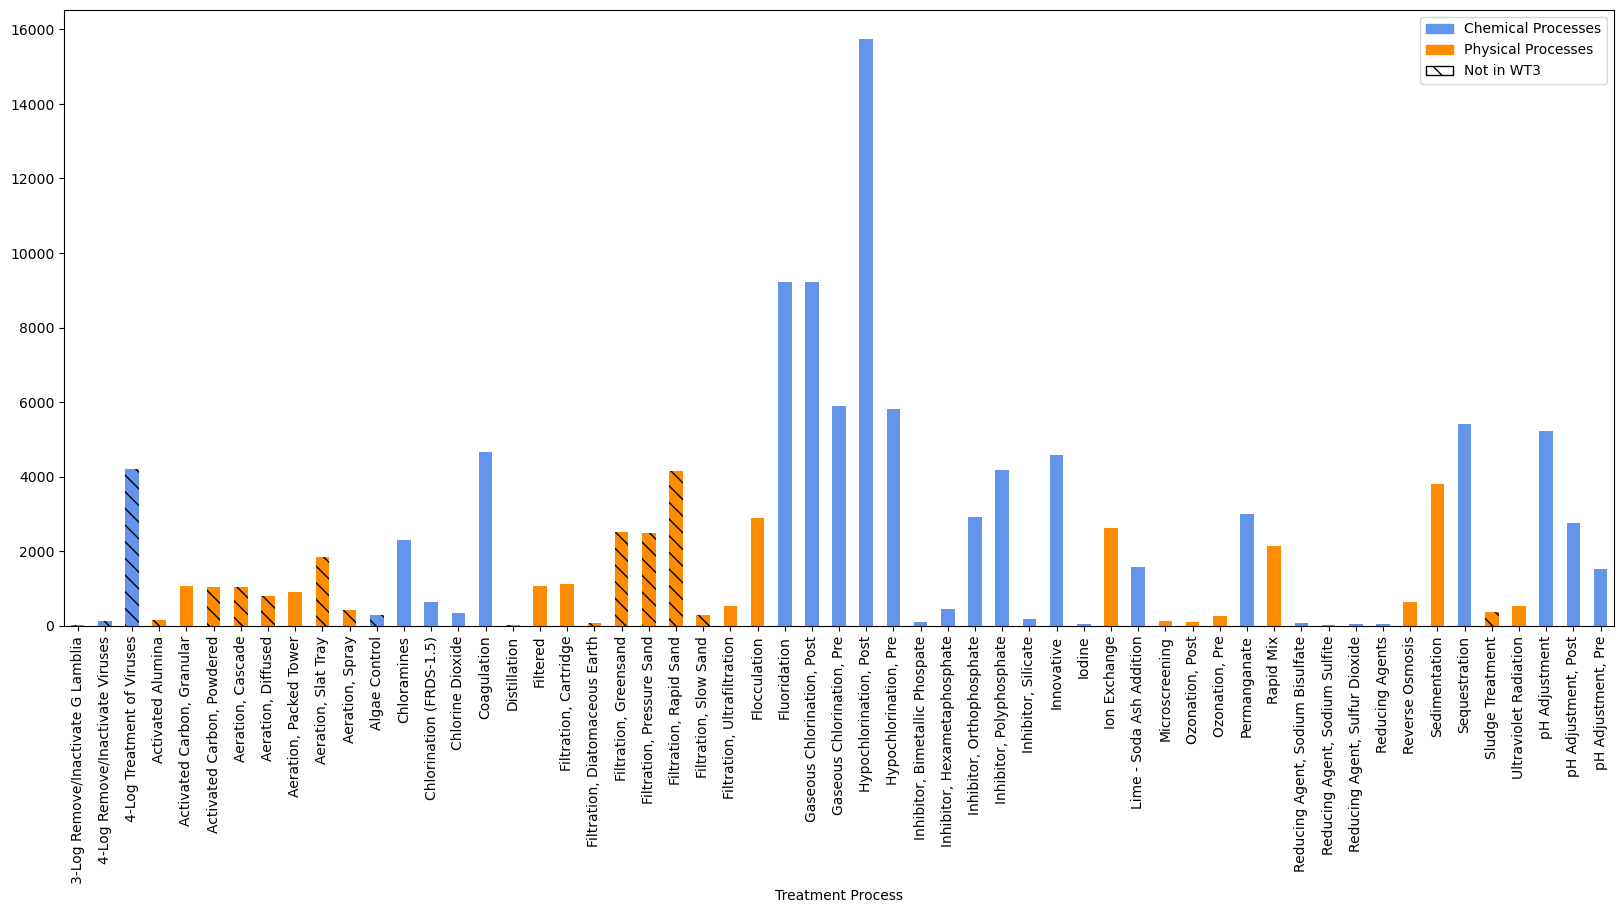

In [18]:
unique_treatment_frequency = unique_treatment.groupby(['Treatment Process']).sum().reset_index()
# unique_treatment_frequency = unique_treatment_frequency.sort_values('Frequency',ascending=False)
unique_treatment_frequency = unique_treatment_frequency.merge(treatment_classification, left_on='Treatment Process', right_on='treatment_process')


fig, ax = plt.subplots()
unique_treatment_frequency.plot.bar(ax = ax, x='Treatment Process', y = 'Frequency', figsize=(20,8))
bars = ax.patches
hatches = ["" if x == 'yes' else '\\\\' for x in unique_treatment_frequency['In WT3']]
colors = ["cornflowerblue" if x == 'chemical' else 'darkorange' for x in unique_treatment_frequency['physical_chemical']]

for bar,hatch,color in zip(bars,hatches,colors):
    bar.set_facecolor(color)
    bar.set_hatch(hatch)

chemical_patch = mpatches.Patch(edgecolor='black', color = "cornflowerblue" , label = 'Chemical Processes')
physical_patch = mpatches.Patch(edgecolor='black', color = "darkorange" , label = 'Physical Processes')
in_wt3 = mpatches.Patch(edgecolor='black', facecolor= 'white', hatch = "\\" , label = 'Not in WT3')

ax.legend(handles=[chemical_patch,physical_patch,in_wt3])
# ax.set_yscale('log')    

In [19]:
# sdwis_filtered.head(5)

In [20]:
# Which process occur together most frequently? 

# Assign codes to each process

unique_treatment_process_code = unique_treatment_process.sort_values(by=0).reset_index(drop=True)
unique_treatment_process_code.reset_index(inplace=True)
unique_treatment_process_code.rename(columns={'index':'Code', 0:'Treatment Process'},inplace=True)
# unique_treatment_process_code.head(5)

sdwis_frequency_mapping = sdwis_filtered[['PWS ID','Facility Id','Treatment Process']]
sdwis_frequency_mapping = sdwis_frequency_mapping.merge(unique_treatment_process_code, left_on ='Treatment Process', right_on = 'Treatment Process')

sdwis_frequency_mapping.head(5)

,PWS ID,Facility Id,Treatment Process,Code
0,WY5680092,15793,"Activated Carbon, Powdered",11
1,WY5600052,14842,"Activated Carbon, Powdered",11
2,WY5600052,14840,"Activated Carbon, Powdered",11
3,WY5600047,15446,"Activated Carbon, Powdered",11
4,WV3305007,4199,"Activated Carbon, Powdered",11


In [21]:
# Iterate through each pair of PWS ID and Facility ID and add the process pair to a treatment process frequency matrix

treatment_process_frequency_matrix = np.zeros((len(unique_treatment_process_code),len(unique_treatment_process_code)))

for pws_id in sdwis_frequency_mapping['PWS ID'].unique():
    temp_pws = sdwis_frequency_mapping[sdwis_frequency_mapping['PWS ID']==pws_id]
    for facility_id in temp_pws['Facility Id'].unique():
        temp_facility = temp_pws[temp_pws['Facility Id']==facility_id]
        units = temp_facility['Code'].unique()

        for i in units:
            for j in units:
                if i!=j:
                    treatment_process_frequency_matrix[i,j] = treatment_process_frequency_matrix[i,j] + 1


In [22]:
df = pd.DataFrame(data=treatment_process_frequency_matrix.astype(float))
# df.to_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\treatment_process_frequency_matrix.csv')

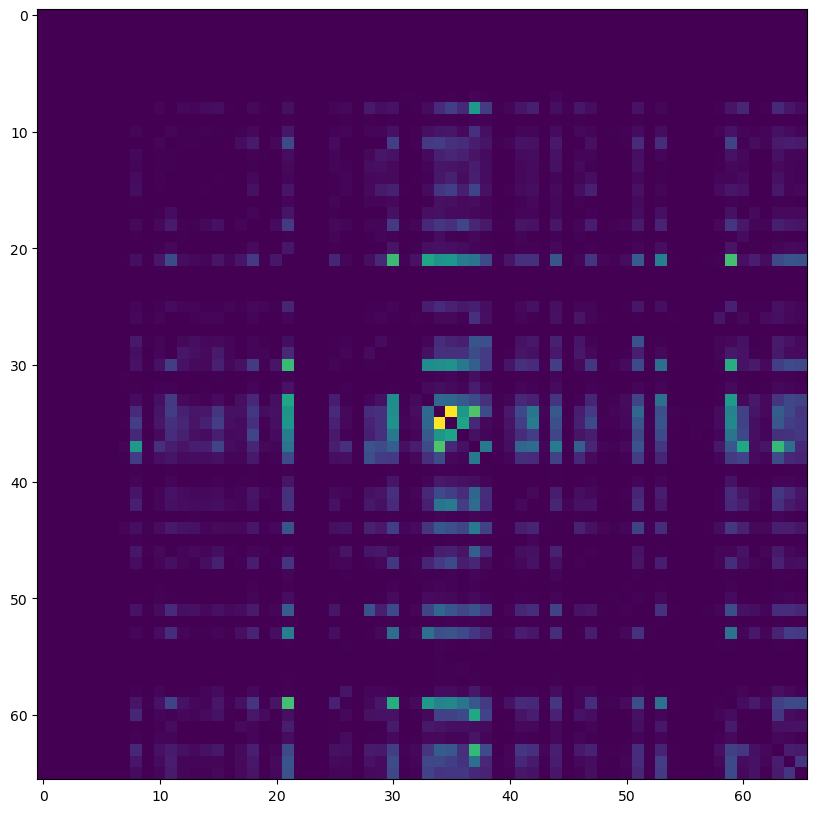

In [26]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(treatment_process_frequency_matrix)